# Model Evaluation

Process 
1. Import data & set up dummy variables
    * drop 1 column for each grouping!
2. Split data: 
    * Train / Test: X, X_test, y, y_test (~20%)
    * Train / Val: X_train, X_val, y_train, y_val (~60%?)
3. Create 3 Models: Linear, Ridge, Lasso
    * SCALE: Ridge & Lasso
    * Keep default alphas
    * use KFolds
4. Evaluate basic models on scoring (r2 train, r2 val)
    * Use KFolds 
    * if models are really close to one another, tune alphas
    * Pick an alpha range to loop through and compare results 
5. Tune alphas for Ridge & Lasso
    * difference between r2 train and r2 val will be guide
    * if r2 train > r2 val --> overfitting --> increase alpha
6. Pick best version of each model to evaluate
    * linear
    * ridge at best alpha
    * lasso at best alpha
7. RETRAIN best model on entire training data (X)
8. Evaluate model against hold out data (predict x_test vs. y_test) 
    * r2 train versus r2 test
    * if difference is significant, more model tuning
    
    
    
More to do (maybe):
* Residual analysis? 
* Dealing with outliers in training data? 
* Charts (predicted versus actual)!

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plb 
%matplotlib inline

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, lars_path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

## Data Import & Setup

In [2]:
sf = pd.read_csv('data_files/sf_clean.csv')

# Reformatting hood_district names
sf['hood_district'] = sf['hood_district'].astype(int)
sf['hood_district'] = sf['hood_district'].astype(str)

In [3]:
sf.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7


### Dropping Features

#### Drop  Pets, Housing Type

In [4]:
sf = sf.drop(['pets', 'housing_type'], axis=1)

In [5]:
sf.head(3)

,price,sqft,beds,bath,laundry,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(b) protected,7
1,3500,550.0,1.0,1.0,(a) in-unit,(b) protected,7
2,5100,1300.0,2.0,1.0,(a) in-unit,(d) no parking,7


In [6]:
#sns.pairplot(sf, aspect=1.25, corner=True);

In [7]:
sf = pd.get_dummies(sf)

In [8]:
sf.columns

Index(['price', 'sqft', 'beds', 'bath', 'laundry_(a) in-unit',
       'laundry_(b) on-site', 'laundry_(c) no laundry', 'parking_(a) valet',
       'parking_(b) protected', 'parking_(c) off-street',
       'parking_(d) no parking', 'hood_district_1', 'hood_district_10',
       'hood_district_2', 'hood_district_3', 'hood_district_4',
       'hood_district_5', 'hood_district_6', 'hood_district_7',
       'hood_district_8', 'hood_district_9'],
      dtype='object')

In [9]:
cols_to_drop = ['laundry_(c) no laundry',
               #'pets_(d) no pets', 
               #'housing_type_(c) multi',
               'parking_(d) no parking',
               'hood_district_10'
               ]

sf = sf.drop(cols_to_drop, axis=1)

In [10]:
sf.head(3)

,price,sqft,beds,bath,laundry_(a) in-unit,laundry_(b) on-site,parking_(a) valet,parking_(b) protected,parking_(c) off-street,hood_district_1,hood_district_2,hood_district_3,hood_district_4,hood_district_5,hood_district_6,hood_district_7,hood_district_8,hood_district_9
0,6800,1600.0,2.0,2.0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
1,3500,550.0,1.0,1.0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
2,5100,1300.0,2.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


## Feature Engineering

### All Features

##### Best Model Output

Linear -- overfitting 
* Linear Regression train R^2: 0.78184
* Linear Regression val R^2: 0.67066

Ridge -- good candidate
* Ridge Regression test R^2: 0.75815
* Ridge Regression val R^2: 0.78565

Lasso -- good candidate
* Lasso Regression test R^2: 0.75885
* Lasso Regression val R^2: 0.78052

### Quadratic on Bed and Bath

In [11]:
sf['beds^2'] = sf['beds']**2
sf['bath^2'] = sf['bath']**2

##### Best Model Output 

Linear -- still overfitting
* Linear Regression train R^2: 0.78595
* Linear Regression val R^2: 0.69627

Ridge -- improvement!
* Ridge Regression test R^2: 0.76921
* Ridge Regression val R^2: 0.78664

Lasso -- improvement!
* Lasso Regression test R^2: 0.75915
* Lasso Regression val R^2: 0.78483

### Cubic on Bed and Bath

In [12]:
# sf['beds^3'] = sf['beds']**3
# sf['bath^3'] = sf['bath']**3

##### Best Model Output 

Linear -- still overfitting
* Linear Regression train R^2: 0.78637
* Linear Regression val R^2: 0.69691

Ridge -- score decreased from quadratic
* Ridge Regression test R^2: 0.76689
* Ridge Regression val R^2: 0.78111

Lasso -- score decreased from quadratic
* Lasso Regression test R^2: 0.76183
* Lasso Regression val R^2: 0.78245

### Quadratic - Just Beds

In [13]:
#sf['beds^2'] = sf['beds']**2

##### Best Model Output 

Linear -- still overfitting
* Linear Regression train R^2: 0.78233
* Linear Regression val R^2: 0.67072

Ridge -- not better than quadratic on both beds and bath
* Ridge Regression test R^2: 0.75888
* Ridge Regression val R^2: 0.78402

Lasso -- not better than quadratic on both beds and bath
* Lasso Regression test R^2: 0.75996
* Lasso Regression val R^2: 0.78091

### Cubic - Just Beds

In [14]:
# sf['beds^3'] = sf['beds']**3

##### Best Model Output 

Linear -- still overfitting
* Linear Regression train R^2: 0.78270
* Linear Regression val R^2: 0.67044

Ridge -- not better than quadratic on both beds and bath
* Ridge Regression test R^2: 0.75935
* Ridge Regression val R^2: 0.78292

Lasso -- not better than quadratic on both beds and bath
* Lasso Regression test R^2: 0.76062
* Lasso Regression val R^2: 0.77847

### Outcome & Decision for model

Quadratic on `beds` and `bath` produces the best models with **Ridge** model performing the best. 


Continue with quadratic transformation on `beds` and `bath` features. 

## Training & Hold-Out Splits

### Train / Test

In [15]:
X, y = sf.drop('price',axis=1), sf['price']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

#### OUTLIERS??

### Train / Validation

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.20, random_state=10)

In [17]:
# Scaling for Ridge & Lasso 

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

## Models

### Linear

In [18]:
lin = LinearRegression()

lin.fit(X_train, y_train)
print(f'Linear Regression train R^2: {lin.score(X_train, y_train):.5f}')
print(f'Linear Regression val R^2: {lin.score(X_val, y_val):.5f}')

Linear Regression train R^2: 0.78514
Linear Regression val R^2: 0.69811


### Ridge

In [19]:
rid = Ridge()

rid.fit(X_train_scaled, y_train)
print(f'Ridge Regression test R^2: {rid.score(X_train_scaled, y_train):.5f}')
print(f'Ridge Regression val R^2: {rid.score(X_val_scaled, y_val):.5f}')

Ridge Regression test R^2: 0.78509
Ridge Regression val R^2: 0.69655


### Lasso

In [20]:
las = Lasso()

las.fit(X_train_scaled, y_train)
print(f'Lasso Regression test R^2: {las.score(X_train_scaled, y_train):.5f}')
print(f'Lasso Regression val R^2: {las.score(X_val_scaled, y_val):.5f}')

Lasso Regression test R^2: 0.78496
Lasso Regression val R^2: 0.69543


### Model Evaluation using KFolds

In [21]:
sf2 = sf.copy()

X, y = sf2.drop('price',axis=1), sf['price']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=30)

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state =12)

cv_lin_r2s, cv_rid_r2s, cv_las_r2s = [], [], []  #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lin = LinearRegression()
    rid = Ridge()
    las = Lasso()

    lin.fit(X_train, y_train)
    cv_lin_r2s.append(lin.score(X_val, y_val))
    
    #ridge/lasso with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    rid.fit(X_train_scaled, y_train)
    cv_rid_r2s.append(rid.score(X_val_scaled, y_val))
    
    
    #lasso with feature scaling
    las.fit(X_train_scaled, y_train)
    cv_las_r2s.append(las.score(X_val_scaled, y_val))

print('Simple scores: ', cv_lin_r2s)
print('Ridge scores: ', cv_rid_r2s)
print('Lasso scores: ', cv_las_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lin_r2s):.5f} +- {np.std(cv_lin_r2s):.5f}')
print(f'Ridge mean cv r^2: {np.mean(cv_rid_r2s):.5f} +- {np.std(cv_rid_r2s):.5f}')
print(f'Lasso mean cv r^2: {np.mean(cv_las_r2s):.5f} +- {np.std(cv_las_r2s):.5f}')

Simple scores:  [0.8197150323945377, 0.6834608818726107, 0.700738675217424, 0.714479100433844, 0.7839250415794152]
Ridge scores:  [0.8185888623389794, 0.6859954956240167, 0.6978368877274586, 0.7165615679464201, 0.7954957894679633]
Lasso scores:  [0.8195102386719904, 0.6856076604546292, 0.6984367433202765, 0.7151850060797156, 0.7890896741178122] 

Simple mean cv r^2: 0.74046 +- 0.05229
Ridge mean cv r^2: 0.74290 +- 0.05377
Lasso mean cv r^2: 0.74157 +- 0.05296


## Alpha Tuning - Ridge & Lasso

In [23]:
sf3 = sf.copy()

X, y = sf3.drop('price',axis=1), sf['price']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=37)

In [25]:
# Scalilng features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

In [26]:
type(X_train_scaled), type(X_val_scaled), type(X_test_scaled)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

### Lasso

In [27]:
alphavec = 10**np.linspace(-2,2,1000)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train_scaled, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.00926219e-02, 1.01861017e-02, 1.02804473e-02,
       1.03756668e-02, 1.04717682e-02, 1.05687597e-02, 1.06666496e-02,
       1.07654461e-02, 1.08651577e-02, 1.09657929e-02, 1.10673602e-02,
       1.11698682e-02, 1.12733256e-02, 1.13777413e-02, 1.14831241e-02,
       1.15894830e-02, 1.16968270e-02, 1.18051653e-02, 1.19145070e-02,
       1.20248614e-02, 1.21362380e-0...
       8.08924349e+01, 8.16416760e+01, 8.23978568e+01, 8.31610415e+01,
       8.39312950e+01, 8.47086827e+01, 8.54932707e+01, 8.62851257e+01,
       8.70843150e+01, 8.78909065e+01, 8.87049689e+01, 8.95265713e+01,
       9.03557835e+01, 9.11926760e+01, 9.20373200e+01, 9.28897872e+01,
       9.37501502e+01, 9.46184819e+01, 9.54948564e+01, 9.63793480e+01,
       9.72720319e+01, 9.81729841e+01, 9.90822810e+01, 1.00000000e+02]),
        cv=5)

In [28]:
las_alpha = lasso_model.alpha_
las_alpha

14.560059950206485

In [29]:
las = Lasso(alpha=las_alpha)

las.fit(X_train_scaled, y_train)
print(f'Lasso Regression test R^2: {las.score(X_train_scaled, y_train):.5f}')
print(f'Lasso Regression val R^2: {las.score(X_val_scaled, y_val):.5f}')

Lasso Regression test R^2: 0.75901
Lasso Regression val R^2: 0.78712


### Ridge

In [30]:
alphavec = 10**np.linspace(-2,2,750)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.01237277e-02, 1.02489862e-02, 1.03757945e-02,
       1.05041718e-02, 1.06341375e-02, 1.07657112e-02, 1.08989128e-02,
       1.10337625e-02, 1.11702807e-02, 1.13084879e-02, 1.14484052e-02,
       1.15900537e-02, 1.17334547e-02, 1.18786300e-02, 1.20256015e-02,
       1.21743915e-02, 1.23250224e-02, 1.24775170e-02, 1.26318984e-02,
       1.27881900e-02, 1.29464153e-0...
       7.35340780e+01, 7.44438980e+01, 7.53649750e+01, 7.62974483e+01,
       7.72414588e+01, 7.81971493e+01, 7.91646644e+01, 8.01441504e+01,
       8.11357552e+01, 8.21396290e+01, 8.31559235e+01, 8.41847923e+01,
       8.52263911e+01, 8.62808774e+01, 8.73484105e+01, 8.84291521e+01,
       8.95232653e+01, 9.06309158e+01, 9.17522710e+01, 9.28875004e+01,
       9.40367758e+01, 9.52002709e+01, 9.63781617e+01, 9.75706262e+01,
       9.87778448e+01, 1.00000000e+02]),
        cv=5)

In [31]:
rid_alpha = ridge_model.alpha_
rid_alpha

22.035563736348692

In [32]:
rid = Ridge(alpha=rid_alpha)

rid.fit(X_train_scaled, y_train)
print(f'Ridge Regression test R^2: {rid.score(X_train_scaled, y_train):.5f}')
print(f'Ridge Regression val R^2: {rid.score(X_val_scaled, y_val):.5f}')

Ridge Regression test R^2: 0.76749
Ridge Regression val R^2: 0.79167


### Coefficients

In [33]:
lin_coefs = lin.coef_
rid_coefs = rid.coef_
las_coefs = las.coef_

features = sf2.columns[1:]

coef_data = {'Features': features,
             'Linear': lin_coefs,
             'Ridge': rid_coefs,
             'Lasso': las_coefs}

coef_df = pd.DataFrame(coef_data)
coef_df

,Features,Linear,Ridge,Lasso
0,sqft,1.789796,822.885869,901.596824
1,beds,294.433497,90.353294,15.295431
2,bath,-2625.201812,-212.176656,-72.166037
3,laundry_(a) in-unit,190.678061,114.318460,116.017429
4,laundry_(b) on-site,-94.316680,-23.684171,-0.000000
5,parking_(a) valet,1181.504715,248.470603,231.297681
6,parking_(b) protected,96.935670,97.926021,67.568263
7,parking_(c) off-street,350.114601,84.265761,65.125080
8,hood_district_1,533.003288,75.192218,0.000000
9,hood_district_2,577.298665,64.902392,-0.000000


### Full Train & Evaluation

In [34]:
X, y = sf3.drop('price',axis=1), sf['price']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Scaling values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X.values)
X_test_scaled = scaler.transform(X_test.values)

#### Ridge

In [35]:
rid = Ridge(alpha=rid_alpha)

rid.fit(X_train_scaled, y)

Ridge(alpha=22.035563736348692)

In [36]:
print(f'Ridge Regression full-train R^2: {rid.score(X_train_scaled, y):.5f}')
print(f'Ridge Regression test R^2: {rid.score(X_test_scaled, y_test):.5f}')

Ridge Regression full-train R^2: 0.77299
Ridge Regression test R^2: 0.77977


#### Lasso

In [37]:
las = Lasso(alpha=las_alpha)

las.fit(X_train_scaled, y)

Lasso(alpha=14.560059950206485)

In [38]:
print(f'Lasso Regression full-train R^2: {las.score(X_train_scaled, y):.5f}')
print(f'Lasso Regression test R^2: {las.score(X_test_scaled, y_test):.5f}')

Lasso Regression full-train R^2: 0.76188
Lasso Regression test R^2: 0.77357


## Evaluation

### Plotting Residuals

In [39]:
rid_prediction = rid.predict(X_train_scaled)
rid_residual = (y - rid_prediction)

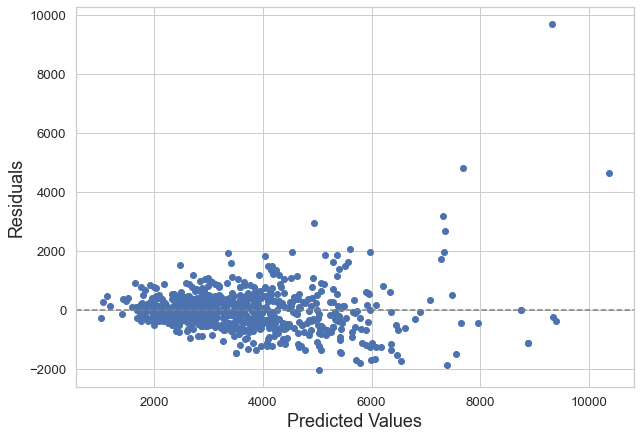

In [40]:

plt.figure(figsize=(10, 7))
plt.scatter(rid_prediction, rid_residual)    

plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Predicted Values', fontsize=18)
plt.ylabel('Residuals', fontsize=18);

### Actual versus Predicted

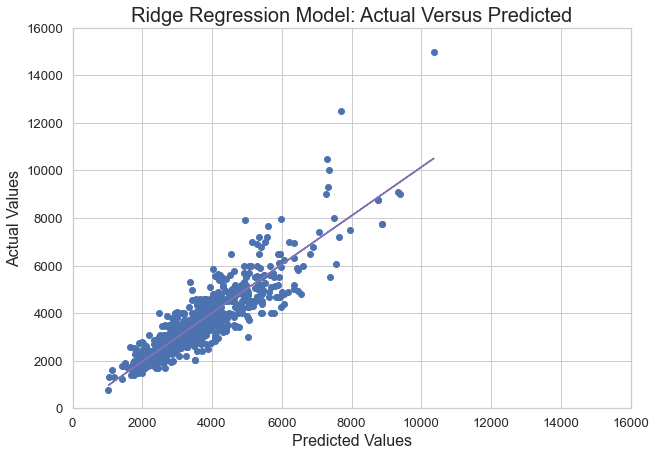

In [41]:


plt.figure(figsize=(10, 7))
plt.scatter(rid_prediction, y) 

z = np.polyfit(rid_prediction, y, 1)
p = np.poly1d(z)
plb.plot(rid_prediction, p(rid_prediction), 'm-')

plt.xlim(0, 16000)
plt.ylim(0, 16000)

plt.title('Ridge Regression Model: Actual Versus Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16);